In [7]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
#import pyarrow.feather as feather
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.model_selection import train_test_split
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score

# import xgboost as xgb
import optuna
from optuna import Trial, visualization



In [8]:

def save_feather(data_frame,folder,name):
    data_frame = pd.DataFrame(data_frame)
    data_frame.columns = data_frame.columns.astype(str)
    # data_frame.reset_index(drop=True)
    data_frame.reset_index().to_feather(folder+name+'.feather')


# load dataframe to feather
# path = ""
# load = feather.read_dataframe(path)


In [9]:
''' read data and insert into a combined dataframe'''

# data1 = pd.read_csv('sim_resultsNUC1.csv')
# data2 = pd.read_csv('sim_resultsNUC2.csv')
# data22 = pd.read_csv('sim_resultsNUC3.csv')

# data3 = pd.read_csv('sim_resultslinux1.csv')
# data4 = pd.read_csv('sim_resultslinux2.csv')
# data5 = pd.read_csv('sim_resultslinux3.csv')

# to_merge = [data1,data2,data22,data3,data4,data5]
# data = pd.concat(to_merge, ignore_index=True)
data = pd.read_csv('6dof_dataset.csv')
data = data.drop(columns=['Unnamed: 0'])
print("Dataframe Columns",data.columns)

data

Dataframe Columns Index(['Arm_ID', 'Point number', 'Move duration', 'Success',
       'Manipulability - mu', 'Mid joint proximity', 'Max Mid joint proximity',
       'Sum Mid joint proximity- all joints', 'Joint1 type', 'Joint1 axis',
       'Link1 length', 'Joint2 type', 'Joint2 axis', 'Link2 length',
       'Joint3 type', 'Joint3 axis', 'Link3 length', 'Joint4 type',
       'Joint4 axis', 'Link4 length', 'Joint5 type', 'Joint5 axis',
       'Link5 length', 'Joint6 type', 'Joint6 axis', 'Link6 length'],
      dtype='object')


,Arm_ID,Point number,Move duration,Success,Manipulability - mu,Mid joint proximity,Max Mid joint proximity,Sum Mid joint proximity- all joints,Joint1 type,Joint1 axis,...,Link3 length,Joint4 type,Joint4 axis,Link4 length,Joint5 type,Joint5 axis,Link5 length,Joint6 type,Joint6 axis,Link6 length
0,_roll_z_0_1_pitch_y_0_3_pris_z_0_1_pris_y_0_7_...,1,1.035686,False,NaN,NaN,NaN,NaN,roll,z,...,0.1,pris,y,0.7,pitch,y,0.1,pitch,x,0.7
1,_roll_z_0_1_pitch_y_0_3_pris_z_0_1_pris_y_0_7_...,2,1.021969,False,NaN,NaN,NaN,NaN,roll,z,...,0.1,pris,y,0.7,pitch,y,0.1,pitch,x,0.7
2,_roll_z_0_1_pitch_y_0_3_pris_z_0_1_pris_y_0_7_...,3,1.014387,False,NaN,NaN,NaN,NaN,roll,z,...,0.1,pris,y,0.7,pitch,y,0.1,pitch,x,0.7
3,_roll_z_0_1_pitch_y_0_3_pris_z_0_1_pris_y_0_7_...,4,1.031590,False,NaN,NaN,NaN,NaN,roll,z,...,0.1,pris,y,0.7,pitch,y,0.1,pitch,x,0.7
4,_roll_z_0_1_pitch_y_0_3_pris_z_0_1_pris_y_0_7_...,5,1.027085,False,NaN,NaN,NaN,NaN,roll,z,...,0.1,pris,y,0.7,pitch,y,0.1,pitch,x,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025395,_roll_z_0_1_roll_y_0_7_pris_z_0_5_pris_y_0_1_r...,6,2.520783,True,0.067,[0.019 0.068 0.024 0.037 0.105 0. 0.001],0.105,0.254,roll,z,...,0.5,pris,y,0.1,roll,x,0.1,pitch,y,0.3
1025396,_roll_z_0_1_roll_y_0_7_pris_z_0_5_pris_y_0_1_r...,7,2.629729,True,0.171,[0.023 0.077 0.049 0.087 0.045 0. 0.002],0.087,0.283,roll,z,...,0.5,pris,y,0.1,roll,x,0.1,pitch,y,0.3
1025397,_roll_z_0_1_roll_y_0_7_pris_z_0_5_pris_y_0_1_r...,8,2.423478,True,0.491,[0.121 0.083 0.074 0.124 0.045 0. 0.009],0.124,0.456,roll,z,...,0.5,pris,y,0.1,roll,x,0.1,pitch,y,0.3
1025398,_roll_z_0_1_roll_y_0_7_pris_z_0_5_pris_y_0_1_r...,9,1.420032,True,0.543,[0.096 0.078 0.075 0.125 0.048 0. 0.009],0.125,0.431,roll,z,...,0.5,pris,y,0.1,roll,x,0.1,pitch,y,0.3


In [10]:
data.shape

(1025400, 26)

In [11]:
'''Data Understanding'''

''' Merge the data of the 10 points of each robotic arm to 1 sample'''
grouped_data = data.groupby(['Arm_ID']).agg(Success_Rates=pd.NamedAgg(column="Success", aggfunc='mean'),
    Min_Manipulability=pd.NamedAgg(column='Manipulability - mu', aggfunc='min'),
    Max_Manipulability=pd.NamedAgg(column='Manipulability - mu', aggfunc='max'),
    Manipulability_Rates=pd.NamedAgg(column='Manipulability - mu', aggfunc='mean'),
    MaxSum_Mid_joint_proximity=pd.NamedAgg(column='Sum Mid joint proximity- all joints', aggfunc='max')).reset_index()


In [12]:
''' count NULL values by column'''
print("NULL values by column\n",grouped_data.isnull().sum(axis = 0))


''' Analyze Success Rates'''
max_success = grouped_data["Success_Rates"].max()
min_success = grouped_data["Success_Rates"].min()

print("\nMax success", max_success)
print("Min success", min_success)

''' Analyze Manipulability Rates'''
max_mani_rate = grouped_data["Manipulability_Rates"].max()
min_mani_rate = grouped_data["Manipulability_Rates"].min()

print("\nMax Manipulability_Rates", max_mani_rate)
print("Min Manipulability_Rates", min_mani_rate)


NULL values by column
 Arm_ID                            0
Success_Rates                     0
Min_Manipulability            73159
Max_Manipulability            73159
Manipulability_Rates          73159
MaxSum_Mid_joint_proximity    73159
dtype: int64

Max success 1.0
Min success 0.0

Max Manipulability_Rates 3.3787
Min Manipulability_Rates 0.0


In [13]:
'''Check for duplicate arms '''
df_duplicates = grouped_data.duplicated(subset = ['Arm_ID'])
df_duplicates.value_counts()

False    102540
dtype: int64

In [14]:
''' split arm name to features '''
# new data frame with split value columns
new = grouped_data["Arm_ID"].str.split("_", expand=True)

grouped_data["Joint1 type"] = new[1]
grouped_data["Joint1 axis"] = new[2]
grouped_data["Link1 length"] = new[3]+"."+new[4]

grouped_data["Joint2 type"] = new[5]
grouped_data["Joint2 axis"] = new[6]
grouped_data["Link2 length"] = new[7]+"."+new[8]

grouped_data["Joint3 type"] = new[9]
grouped_data["Joint3 axis"] = new[10]
grouped_data["Link3 length"] = new[11]+"."+new[12]

grouped_data["Joint4 type"] = new[13]
grouped_data["Joint4 axis"] = new[14]
grouped_data["Link4 length"] = new[15]+"."+new[16]

grouped_data["Joint5 type"] = new[17]
grouped_data["Joint5 axis"] = new[18]
grouped_data["Link5 length"] = new[19]+"."+new[20]

grouped_data["Joint6 type"] = new[21]
grouped_data["Joint6 axis"] = new[22]
grouped_data["Link6 length"] = new[23]+"."+new[24]

grouped_data = grouped_data.drop(['Arm_ID'], axis=1)


grouped_data

,Success_Rates,Min_Manipulability,Max_Manipulability,Manipulability_Rates,MaxSum_Mid_joint_proximity,Joint1 type,Joint1 axis,Link1 length,Joint2 type,Joint2 axis,...,Link3 length,Joint4 type,Joint4 axis,Link4 length,Joint5 type,Joint5 axis,Link5 length,Joint6 type,Joint6 axis,Link6 length
0,0.0,NaN,NaN,NaN,NaN,roll,z,0.1,pitch,y,...,0.1,pitch,x,0.1,pitch,x,0.3,roll,x,0.7
1,0.0,NaN,NaN,NaN,NaN,roll,z,0.1,pitch,y,...,0.1,pitch,x,0.1,pitch,x,0.5,roll,x,0.5
2,0.0,NaN,NaN,NaN,NaN,roll,z,0.1,pitch,y,...,0.1,pitch,x,0.1,pitch,x,0.7,roll,x,0.7
3,0.0,NaN,NaN,NaN,NaN,roll,z,0.1,pitch,y,...,0.1,pitch,x,0.1,pitch,x,0.7,roll,y,0.7
4,0.0,NaN,NaN,NaN,NaN,roll,z,0.1,pitch,y,...,0.1,pitch,x,0.1,pitch,x,0.7,roll,z,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102535,0.2,2.129,2.265,2.197000,0.354,roll,z,0.1,roll,y,...,0.7,pris,y,0.3,pris,x,0.1,roll,z,0.1
102536,0.7,0.105,0.429,0.212571,3.310,roll,z,0.1,roll,y,...,0.7,pris,z,0.1,pitch,y,0.1,pris,z,0.3
102537,0.0,NaN,NaN,NaN,NaN,roll,z,0.1,roll,y,...,0.7,pris,z,0.3,pitch,y,0.1,roll,x,0.1
102538,1.0,0.121,0.907,0.397400,0.449,roll,z,0.1,roll,y,...,0.7,roll,y,0.1,pitch,y,0.1,roll,x,0.3


In [15]:
'''Change columns order'''
grouped_data = grouped_data[['Joint1 type', 'Joint1 axis', 'Link1 length', 'Joint2 type', 'Joint2 axis',
       'Link2 length', 'Joint3 type', 'Joint3 axis', 'Link3 length',
       'Joint4 type', 'Joint4 axis', 'Link4 length', 'Joint5 type',
       'Joint5 axis', 'Link5 length', 'Joint6 type', 'Joint6 axis',
       'Link6 length','Success_Rates', 'Min_Manipulability', 'Max_Manipulability', 'Manipulability_Rates','MaxSum_Mid_joint_proximity']]

grouped_data


,Joint1 type,Joint1 axis,Link1 length,Joint2 type,Joint2 axis,Link2 length,Joint3 type,Joint3 axis,Link3 length,Joint4 type,...,Joint5 axis,Link5 length,Joint6 type,Joint6 axis,Link6 length,Success_Rates,Min_Manipulability,Max_Manipulability,Manipulability_Rates,MaxSum_Mid_joint_proximity
0,roll,z,0.1,pitch,y,0.1,pitch,x,0.1,pitch,...,x,0.3,roll,x,0.7,0.0,NaN,NaN,NaN,NaN
1,roll,z,0.1,pitch,y,0.1,pitch,x,0.1,pitch,...,x,0.5,roll,x,0.5,0.0,NaN,NaN,NaN,NaN
2,roll,z,0.1,pitch,y,0.1,pitch,x,0.1,pitch,...,x,0.7,roll,x,0.7,0.0,NaN,NaN,NaN,NaN
3,roll,z,0.1,pitch,y,0.1,pitch,x,0.1,pitch,...,x,0.7,roll,y,0.7,0.0,NaN,NaN,NaN,NaN
4,roll,z,0.1,pitch,y,0.1,pitch,x,0.1,pitch,...,x,0.7,roll,z,0.7,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102535,roll,z,0.1,roll,y,0.7,roll,y,0.7,pris,...,x,0.1,roll,z,0.1,0.2,2.129,2.265,2.197000,0.354
102536,roll,z,0.1,roll,y,0.7,roll,y,0.7,pris,...,y,0.1,pris,z,0.3,0.7,0.105,0.429,0.212571,3.310
102537,roll,z,0.1,roll,y,0.7,roll,y,0.7,pris,...,y,0.1,roll,x,0.1,0.0,NaN,NaN,NaN,NaN
102538,roll,z,0.1,roll,y,0.7,roll,y,0.7,roll,...,y,0.1,roll,x,0.3,1.0,0.121,0.907,0.397400,0.449


In [16]:
# grouped_data[['Success_Rates', 'Min_Manipulability', 'Max_Manipulability', 'Manipulability_Rates']] = grouped_data[['Success_Rates', 'Min_Manipulability', 'Max_Manipulability', 'Manipulability_Rates']].astype('float64')
# grouped_data[["Joint1 type","Joint2 type","Joint3 type","Joint4 type","Joint5 type","Joint6 type"]] = grouped_data[["Joint1 type","Joint2 type","Joint3 type","Joint4 type","Joint5 type","Joint6 type"]].astype("string")
# grouped_data[["Joint1 axis","Joint2 axis","Joint3 axis","Joint4 axis","Joint5 axis","Joint6 axis"]]= grouped_data[["Joint1 axis","Joint2 axis","Joint3 axis","Joint4 axis","Joint5 axis","Joint6 axis"]] .astype("string")
# grouped_data[["Link1 length","Link2 length","Link3 length","Link4 length","Link5 length","Link6 length"]] = grouped_data[["Link1 length","Link2 length","Link3 length","Link4 length","Link5 length","Link6 length"]] .astype('float64')


In [17]:
''' Data Pre-Processing/ Data Preparation - Predicted Sucsses'''
'''Drop Joint1 type,Joint1 axis,Link1 length Min_Manipulability, Max_Manipulability, Manipulability_Rates,MaxSum_Mid_joint_proximity'''
grouped_data = grouped_data.drop(columns=["Joint1 type","Joint1 axis",'Link1 length' ,'Min_Manipulability', 'Max_Manipulability', 'Manipulability_Rates','MaxSum_Mid_joint_proximity'])

grouped_data


,Joint2 type,Joint2 axis,Link2 length,Joint3 type,Joint3 axis,Link3 length,Joint4 type,Joint4 axis,Link4 length,Joint5 type,Joint5 axis,Link5 length,Joint6 type,Joint6 axis,Link6 length,Success_Rates
0,pitch,y,0.1,pitch,x,0.1,pitch,x,0.1,pitch,x,0.3,roll,x,0.7,0.0
1,pitch,y,0.1,pitch,x,0.1,pitch,x,0.1,pitch,x,0.5,roll,x,0.5,0.0
2,pitch,y,0.1,pitch,x,0.1,pitch,x,0.1,pitch,x,0.7,roll,x,0.7,0.0
3,pitch,y,0.1,pitch,x,0.1,pitch,x,0.1,pitch,x,0.7,roll,y,0.7,0.0
4,pitch,y,0.1,pitch,x,0.1,pitch,x,0.1,pitch,x,0.7,roll,z,0.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102535,roll,y,0.7,roll,y,0.7,pris,y,0.3,pris,x,0.1,roll,z,0.1,0.2
102536,roll,y,0.7,roll,y,0.7,pris,z,0.1,pitch,y,0.1,pris,z,0.3,0.7
102537,roll,y,0.7,roll,y,0.7,pris,z,0.3,pitch,y,0.1,roll,x,0.1,0.0
102538,roll,y,0.7,roll,y,0.7,roll,y,0.1,pitch,y,0.1,roll,x,0.3,1.0


In [18]:
'''Get Dummies'''
grouped_data = pd.get_dummies(grouped_data, columns = ["Joint2 type","Joint3 type","Joint4 type","Joint5 type","Joint6 type","Joint2 axis","Joint3 axis","Joint4 axis","Joint5 axis","Joint6 axis"])

grouped_data


,Link2 length,Link3 length,Link4 length,Link5 length,Link6 length,Success_Rates,Joint2 type_pitch,Joint2 type_pris,Joint2 type_roll,Joint3 type_pitch,...,Joint3 axis_z,Joint4 axis_x,Joint4 axis_y,Joint4 axis_z,Joint5 axis_x,Joint5 axis_y,Joint5 axis_z,Joint6 axis_x,Joint6 axis_y,Joint6 axis_z
0,0.1,0.1,0.1,0.3,0.7,0.0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
1,0.1,0.1,0.1,0.5,0.5,0.0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
2,0.1,0.1,0.1,0.7,0.7,0.0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
3,0.1,0.1,0.1,0.7,0.7,0.0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
4,0.1,0.1,0.1,0.7,0.7,0.0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102535,0.7,0.7,0.3,0.1,0.1,0.2,0,0,1,0,...,0,0,1,0,1,0,0,0,0,1
102536,0.7,0.7,0.1,0.1,0.3,0.7,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
102537,0.7,0.7,0.3,0.1,0.1,0.0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,0
102538,0.7,0.7,0.1,0.1,0.3,1.0,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0


In [19]:
# train_df = grouped_data_shuffled.sample(frac=0.8,random_state=200) #random state is a seed value
# test_df = grouped_data_shuffled.drop(train_df.index)
# X = train_df.loc[:,train_df.columns != 'Success_Rates']
# Y = train_df.loc[:,train_df.columns == 'Success_Rates']
# X= X.to_numpy()
# Y = Y.to_numpy()
# X = [[float(j) for j in i] for i in X]
# X=np.array(X)

# x_test = test_df.loc[:,test_df.columns != 'Success_Rates']
# y_test = test_df.loc[:,test_df.columns == 'Success_Rates']
# x_test= x_test.to_numpy()
# y_test = y_test.to_numpy()
# x_test = [[float(j) for j in i] for i in x_test]
# x_test= np.array(x_test)
X = grouped_data.loc[:,grouped_data.columns != 'Success_Rates']
Y = grouped_data.loc[:,grouped_data.columns == 'Success_Rates']
X=X.to_numpy()
X = [[float(j) for j in i] for i in X]
X=np.array(X)
Y=Y.to_numpy()



x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=2)
    
    
print("x train\n", x_train.shape)
print("y train\n", y_train.shape)

print("x valid\n", x_valid.shape)
print("y valid\n", y_valid.shape)

print("x test\n", x_test.shape)
print("y test\n", y_test.shape)



x train
 (61524, 34)
y train
 (61524, 1)
x valid
 (20508, 34)
y valid
 (20508, 1)
x test
 (20508, 34)
y test
 (20508, 1)


In [98]:
# define the model
clf1= TabNetRegressor()


Device used : cpu


In [99]:
# fit the model
clf1.fit(
    x_train,y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['mae','rmse'],
    max_epochs=1000 , patience=50,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.08827 | train_mae: 0.19491 | train_rmse: 0.27067 | valid_mae: 0.19579 | valid_rmse: 0.27231 |  0:00:04s
epoch 1  | loss: 0.07227 | train_mae: 0.17536 | train_rmse: 0.26206 | valid_mae: 0.17665 | valid_rmse: 0.26365 |  0:00:10s
epoch 2  | loss: 0.06617 | train_mae: 0.16298 | train_rmse: 0.24743 | valid_mae: 0.16405 | valid_rmse: 0.24949 |  0:00:15s
epoch 3  | loss: 0.06089 | train_mae: 0.152   | train_rmse: 0.23471 | valid_mae: 0.15304 | valid_rmse: 0.23768 |  0:00:20s
epoch 4  | loss: 0.0565  | train_mae: 0.14035 | train_rmse: 0.22661 | valid_mae: 0.14135 | valid_rmse: 0.22928 |  0:00:25s
epoch 5  | loss: 0.05283 | train_mae: 0.14246 | train_rmse: 0.22247 | valid_mae: 0.14374 | valid_rmse: 0.22518 |  0:00:30s
epoch 6  | loss: 0.05153 | train_mae: 0.13912 | train_rmse: 0.22197 | valid_mae: 0.14078 | valid_rmse: 0.22496 |  0:00:35s
epoch 7  | loss: 0.04982 | train_mae: 0.13066 | train_rmse: 0.21692 | valid_mae: 0.13267 | valid_rmse: 0.2209  |  0:00:40s
epoch 8  | loss:

epoch 67 | loss: 0.03474 | train_mae: 0.10111 | train_rmse: 0.17466 | valid_mae: 0.10712 | valid_rmse: 0.188   |  0:05:52s
epoch 68 | loss: 0.03454 | train_mae: 0.10449 | train_rmse: 0.17539 | valid_mae: 0.10995 | valid_rmse: 0.18759 |  0:05:58s
epoch 69 | loss: 0.03463 | train_mae: 0.10278 | train_rmse: 0.1764  | valid_mae: 0.108   | valid_rmse: 0.1876  |  0:06:03s
epoch 70 | loss: 0.0344  | train_mae: 0.10335 | train_rmse: 0.17524 | valid_mae: 0.10939 | valid_rmse: 0.18849 |  0:06:08s
epoch 71 | loss: 0.03454 | train_mae: 0.1023  | train_rmse: 0.17732 | valid_mae: 0.10754 | valid_rmse: 0.18895 |  0:06:13s
epoch 72 | loss: 0.03422 | train_mae: 0.09795 | train_rmse: 0.17329 | valid_mae: 0.10451 | valid_rmse: 0.1881  |  0:06:19s
epoch 73 | loss: 0.03412 | train_mae: 0.10302 | train_rmse: 0.1761  | valid_mae: 0.10896 | valid_rmse: 0.18845 |  0:06:24s
epoch 74 | loss: 0.03405 | train_mae: 0.1017  | train_rmse: 0.17495 | valid_mae: 0.10819 | valid_rmse: 0.18854 |  0:06:29s
epoch 75 | loss:

epoch 134| loss: 0.03253 | train_mae: 0.0983  | train_rmse: 0.16711 | valid_mae: 0.10544 | valid_rmse: 0.18201 |  0:11:45s
epoch 135| loss: 0.03166 | train_mae: 0.0983  | train_rmse: 0.16734 | valid_mae: 0.10543 | valid_rmse: 0.18185 |  0:11:51s
epoch 136| loss: 0.03203 | train_mae: 0.09889 | train_rmse: 0.17032 | valid_mae: 0.10558 | valid_rmse: 0.18406 |  0:11:58s
epoch 137| loss: 0.03219 | train_mae: 0.09842 | train_rmse: 0.16931 | valid_mae: 0.1056  | valid_rmse: 0.18383 |  0:12:04s
epoch 138| loss: 0.03183 | train_mae: 0.09909 | train_rmse: 0.17029 | valid_mae: 0.10573 | valid_rmse: 0.18422 |  0:12:10s
epoch 139| loss: 0.03171 | train_mae: 0.09392 | train_rmse: 0.16678 | valid_mae: 0.10127 | valid_rmse: 0.18231 |  0:12:16s
epoch 140| loss: 0.03208 | train_mae: 0.09585 | train_rmse: 0.16855 | valid_mae: 0.10353 | valid_rmse: 0.18472 |  0:12:21s
epoch 141| loss: 0.03183 | train_mae: 0.09709 | train_rmse: 0.16759 | valid_mae: 0.10416 | valid_rmse: 0.18194 |  0:12:26s
epoch 142| loss:

epoch 201| loss: 0.03084 | train_mae: 0.09115 | train_rmse: 0.16279 | valid_mae: 0.09922 | valid_rmse: 0.1801  |  0:17:28s
epoch 202| loss: 0.03056 | train_mae: 0.09598 | train_rmse: 0.16436 | valid_mae: 0.10359 | valid_rmse: 0.18025 |  0:17:33s
epoch 203| loss: 0.03066 | train_mae: 0.09363 | train_rmse: 0.16423 | valid_mae: 0.10176 | valid_rmse: 0.18176 |  0:17:37s
epoch 204| loss: 0.03089 | train_mae: 0.09212 | train_rmse: 0.1638  | valid_mae: 0.09934 | valid_rmse: 0.17959 |  0:17:43s
epoch 205| loss: 0.03077 | train_mae: 0.09504 | train_rmse: 0.16307 | valid_mae: 0.10369 | valid_rmse: 0.18086 |  0:17:47s
epoch 206| loss: 0.03056 | train_mae: 0.09211 | train_rmse: 0.16262 | valid_mae: 0.10049 | valid_rmse: 0.18078 |  0:17:52s
epoch 207| loss: 0.03092 | train_mae: 0.09233 | train_rmse: 0.16251 | valid_mae: 0.10071 | valid_rmse: 0.18049 |  0:17:57s
epoch 208| loss: 0.03056 | train_mae: 0.09548 | train_rmse: 0.16453 | valid_mae: 0.10379 | valid_rmse: 0.18258 |  0:18:02s
epoch 209| loss:

epoch 268| loss: 0.03103 | train_mae: 0.09621 | train_rmse: 0.16685 | valid_mae: 0.10411 | valid_rmse: 0.18347 |  0:22:47s
epoch 269| loss: 0.03089 | train_mae: 0.09707 | train_rmse: 0.16337 | valid_mae: 0.10551 | valid_rmse: 0.18117 |  0:22:52s
epoch 270| loss: 0.03057 | train_mae: 0.09476 | train_rmse: 0.16166 | valid_mae: 0.1039  | valid_rmse: 0.1811  |  0:22:57s
epoch 271| loss: 0.03042 | train_mae: 0.09591 | train_rmse: 0.16641 | valid_mae: 0.10296 | valid_rmse: 0.18206 |  0:23:01s
epoch 272| loss: 0.03011 | train_mae: 0.09448 | train_rmse: 0.16215 | valid_mae: 0.10415 | valid_rmse: 0.18277 |  0:23:06s
epoch 273| loss: 0.03035 | train_mae: 0.0939  | train_rmse: 0.1615  | valid_mae: 0.10339 | valid_rmse: 0.18184 |  0:23:11s
epoch 274| loss: 0.03046 | train_mae: 0.09375 | train_rmse: 0.16231 | valid_mae: 0.10247 | valid_rmse: 0.181   |  0:23:15s
epoch 275| loss: 0.03048 | train_mae: 0.09445 | train_rmse: 0.16712 | valid_mae: 0.10247 | valid_rmse: 0.18449 |  0:23:20s
epoch 276| loss:

In [100]:
preds = clf1.predict(x_test)

test_mse = mean_squared_error(y_pred=preds, y_true=y_test)
test_mae = mean_absolute_error(y_test, preds)
test_rmse = np.sqrt(test_mse)

print(f"BEST VALID SCORE: {clf1.best_cost}")
print(f"MSE TEST SCORE: {test_mse}")
print(f"RMSE TEST SCORE: {test_rmse}")
print(f"MAE TEST SCORE: {test_mae}")

from sklearn.metrics import r2_score
score = r2_score(y_test, preds)
print(score)
print("The accuracy of our model is {}%".format(round(score, 2) *100))

BEST VALID SCORE: 0.179368479751646
MSE TEST SCORE: 0.032689648979989605
RMSE TEST SCORE: 0.18080279029923627
MAE TEST SCORE: 0.10555311600316702
0.5675788244797988
The accuracy of our model is 56.99999999999999%


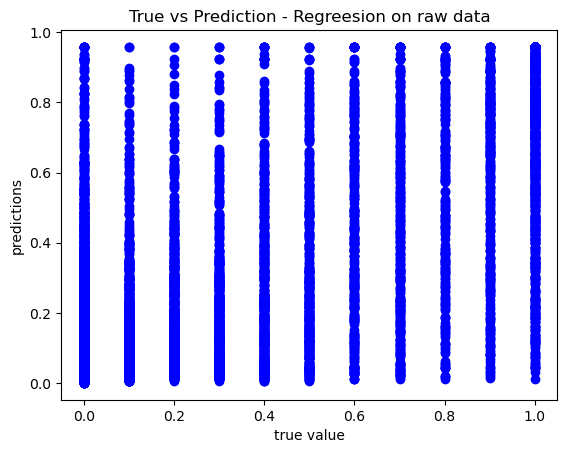

In [101]:
plt.scatter(y_test,preds, c ="blue")
plt.xlabel('true value')
plt.ylabel('predictions')
plt.title('True vs Prediction - Regreesion on raw data')
# To show the plot
plt.show()

In [102]:
clf1.feature_importances_
with np.printoptions(precision=2, suppress=True):
    print(clf1.feature_importances_)
len(clf1.feature_importances_)


[0.   0.   0.   0.   0.1  0.   0.1  0.   0.   0.   0.   0.   0.11 0.
 0.   0.   0.   0.02 0.13 0.   0.33 0.   0.   0.08 0.   0.   0.12 0.
 0.   0.   0.   0.   0.01 0.  ]


34

Text(0.5, 1.0, 'Feature Importances')

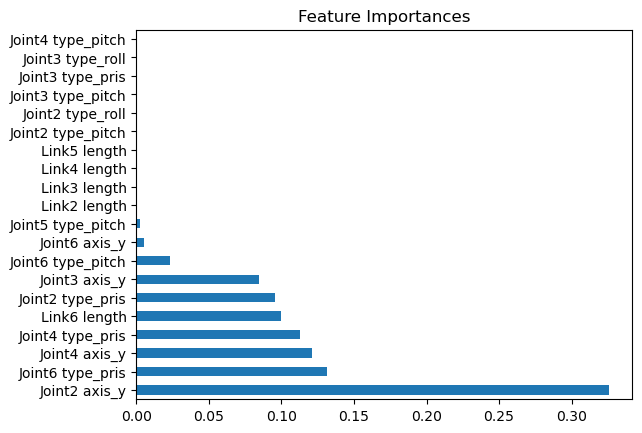

In [103]:
feat_importances = pd.Series(clf1.feature_importances_ ,index = grouped_data.loc[:,grouped_data.columns != 'Success_Rates'].columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.rcParams['figure.figsize'] = [5, 5]
plt.title("Feature Importances")

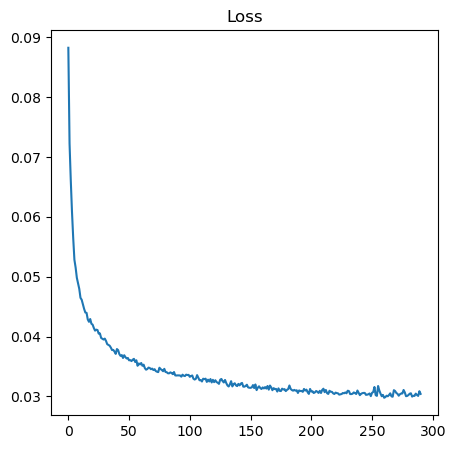

In [104]:
plt.plot(clf1.history['loss'])
plt.title("Loss")
plt.rcParams['figure.figsize'] = [5, 5]

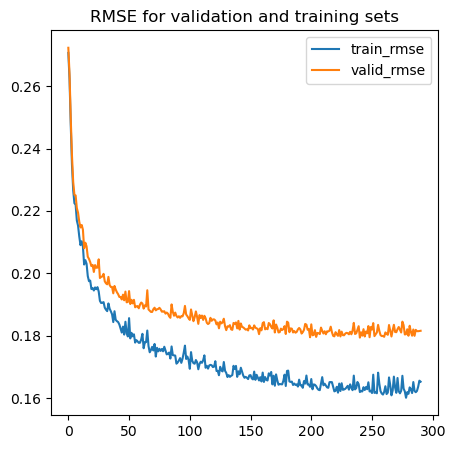

In [105]:
plt.plot(clf1.history['train_rmse'], label= 'train_rmse')
plt.plot(clf1.history['valid_rmse'], label ='valid_rmse')
plt.rcParams['figure.figsize'] = [5, 5]
plt.title("RMSE for validation and training sets")
plt.legend()
plt.savefig('/home/ar1/Desktop/plots/rmse_tabnet_beforTunning_raw.png', bbox_inches='tight')


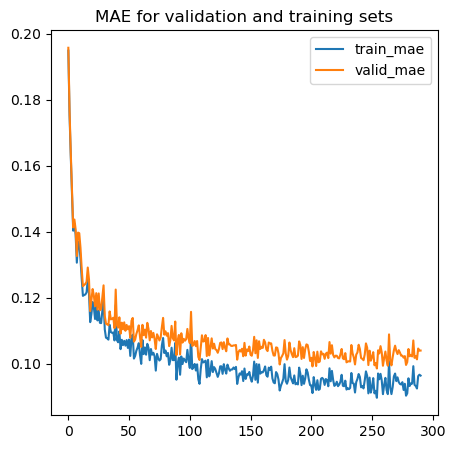

In [106]:
plt.plot(clf1.history['train_mae'], label= 'train_mae')
plt.plot(clf1.history['valid_mae'], label ='valid_mae')
plt.rcParams['figure.figsize'] = [5, 5]
plt.title("MAE for validation and training sets")
plt.legend()
plt.savefig('/home/ar1/Desktop/plots/mae_tabnet_beforTunning_raw.png', bbox_inches='tight')

In [107]:
def Objective(trial):
    mask_type = trial.suggest_categorical("mask_type", ["entmax", "sparsemax"])
    n_da = trial.suggest_int("n_da", 56, 64, step=4)
    n_steps = trial.suggest_int("n_steps", 1, 3, step=1)
    gamma = trial.suggest_float("gamma", 1., 1.4, step=0.2)
    n_shared = trial.suggest_int("n_shared", 1, 3)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)
    tabnet_params = dict(n_d=n_da, n_a=n_da, n_steps=n_steps, gamma=gamma,
                     lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type=mask_type, n_shared=n_shared,
                     scheduler_params=dict(mode="min",
                                           patience=trial.suggest_int("patienceScheduler",low=3,high=10), # changing sheduler patience to be lower than early stopping patience 
                                           min_lr=1e-5,
                                           factor=0.5,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=0,
                     ) #early stopping
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    CV_score_array    =[]
    for train_index, test_index in kf.split(X):
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = Y[train_index], Y[test_index]
        regressor = TabNetRegressor(**tabnet_params)
        regressor.fit(X_train=X_train, y_train=y_train,
                  eval_set=[(X_valid, y_valid)],
                  patience=trial.suggest_int("patience",low=15,high=30), max_epochs=trial.suggest_int('epochs', 1, 100),
                  eval_metric=['rmse','mae'])
        CV_score_array.append(regressor.best_cost)
    avg = np.mean(CV_score_array)
    return avg

In [108]:
study = optuna.create_study(direction="minimize", study_name='TabNet optimization')
study.optimize(Objective, timeout=6*60) #5 hours

[I 2022-12-21 16:45:08,511] A new study created in memory with name: TabNet optimization


Stop training because you reached max_epochs = 20 with best_epoch = 17 and best_val_0_mae = 0.10339
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 20 with best_epoch = 19 and best_val_0_mae = 0.09856
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 20 with best_epoch = 16 and best_val_0_mae = 0.09856
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 20 with best_epoch = 19 and best_val_0_mae = 0.1074
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 20 with best_epoch = 18 and best_val_0_mae = 0.10675
Best weights from best epoch are automatically used!


[I 2022-12-21 16:49:57,861] Trial 0 finished with value: 0.10293100079317381 and parameters: {'mask_type': 'entmax', 'n_da': 56, 'n_steps': 1, 'gamma': 1.4, 'n_shared': 2, 'lambda_sparse': 1.3476897388082293e-05, 'patienceScheduler': 3, 'patience': 23, 'epochs': 20}. Best is trial 0 with value: 0.10293100079317381.


Stop training because you reached max_epochs = 95 with best_epoch = 92 and best_val_0_mae = 0.07895
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 95 with best_epoch = 94 and best_val_0_mae = 0.07734
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 95 with best_epoch = 83 and best_val_0_mae = 0.08013
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 95 with best_epoch = 93 and best_val_0_mae = 0.07896
Best weights from best epoch are automatically used!
Stop training because you reached max_epochs = 95 with best_epoch = 91 and best_val_0_mae = 0.07927
Best weights from best epoch are automatically used!


[I 2022-12-21 18:02:50,257] Trial 1 finished with value: 0.07892845915206409 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 3, 'gamma': 1.2, 'n_shared': 2, 'lambda_sparse': 0.0003498704183387818, 'patienceScheduler': 4, 'patience': 29, 'epochs': 95}. Best is trial 1 with value: 0.07892845915206409.


In [2]:
TabNet_params = {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 3, 'gamma': 1.2, 'n_shared': 2, 'lambda_sparse': 0.0003498704183387818, 'patienceScheduler': 4, 'patience': 29, 'epochs': 95}

In [5]:
final_params = dict(n_d=TabNet_params['n_da'], n_a=TabNet_params['n_da'], n_steps=TabNet_params['n_steps'], gamma=TabNet_params['gamma'],
                     lambda_sparse=TabNet_params['lambda_sparse'], optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type=TabNet_params['mask_type'], n_shared=TabNet_params['n_shared'],
                     scheduler_params=dict(mode="min",
                                           patience=TabNet_params['patienceScheduler'],
                                           min_lr=1e-5,
                                           factor=0.5,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=0,
                     )
epochs = TabNet_params['epochs']
final_params

{'n_d': 64,
 'n_a': 64,
 'n_steps': 3,
 'gamma': 1.2,
 'lambda_sparse': 0.0003498704183387818,
 'optimizer_fn': torch.optim.adam.Adam,
 'optimizer_params': {'lr': 0.02, 'weight_decay': 1e-05},
 'mask_type': 'sparsemax',
 'n_shared': 2,
 'scheduler_params': {'mode': 'min',
  'patience': 4,
  'min_lr': 1e-05,
  'factor': 0.5},
 'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
 'verbose': 0}

In [20]:
regressor = TabNetRegressor(**final_params)
regressor.fit(x_train,y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    eval_name=['train', 'valid'],
    patience=TabNet_params['patience'], max_epochs=epochs,
    eval_metric=['rmse','mae'])

Stop training because you reached max_epochs = 95 with best_epoch = 93 and best_valid_mae = 0.08493
Best weights from best epoch are automatically used!


In [22]:
preds = regressor.predict(x_test)

test_mse = mean_squared_error(y_pred=preds, y_true=y_test)
test_mae = mean_absolute_error(y_pred=preds, y_true=y_test)
test_rmse = np.sqrt(test_mse)

print(f"BEST VALID SCORE: {regressor.best_cost}")
print(f"MSE TEST SCORE: {test_mse}")
print(f"RMSE TEST SCORE: {test_rmse}")
print(f"MAE TEST SCORE: {test_mae}")
from sklearn.metrics import r2_score
score = r2_score(y_test, preds)
print(score)
print("The accuracy of our model is {}%".format(round(score, 2) *100))

BEST VALID SCORE: 0.08492719565135157
MSE TEST SCORE: 0.026193381121731123
RMSE TEST SCORE: 0.16184369348767078
MAE TEST SCORE: 0.08489491758155551
0.6535119522867627
The accuracy of our model is 65.0%


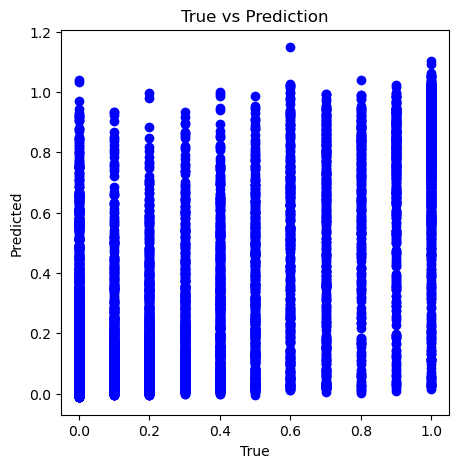

In [27]:
plt.title("True vs Prediction")
plt.scatter(y_test,preds, c ="blue")
plt.xlabel('True')
plt.ylabel('Predicted')
# To show the plot
plt.show()

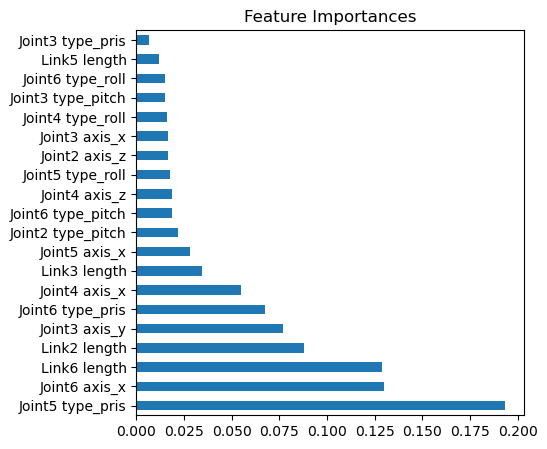

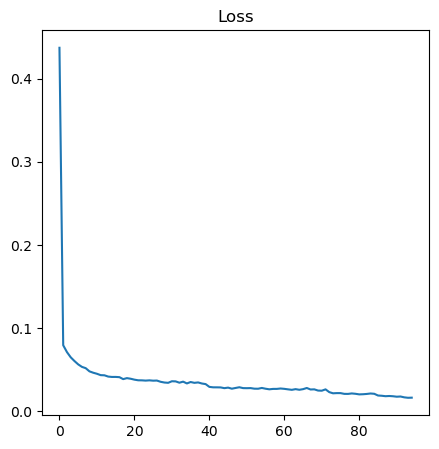

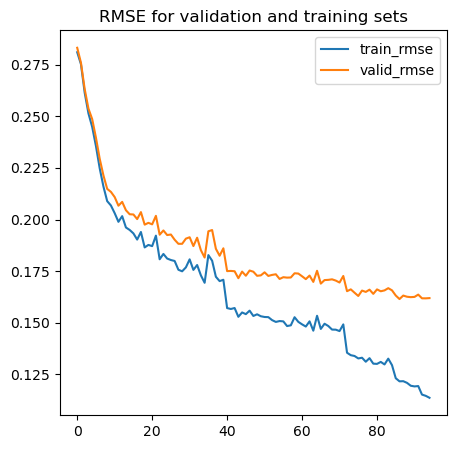

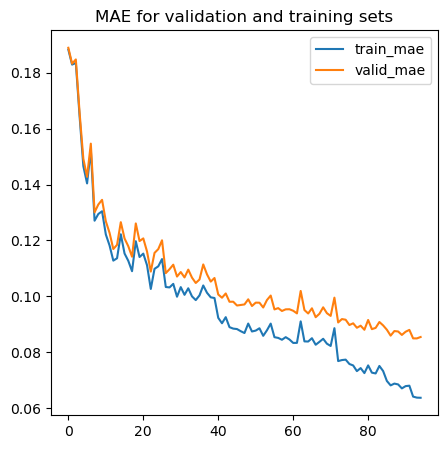

In [25]:
'''TabNet plots after optimization'''
# features importance
feat_importances = pd.Series(regressor.feature_importances_ ,index = grouped_data.loc[:,grouped_data.columns != 'Success_Rates'].columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.rcParams['figure.figsize'] = [5, 5]
plt.title("Feature Importances")
plt.savefig('/home/ar1/Desktop/plots/Feature Importances - afterTunning-raw.png', bbox_inches='tight')
plt.show()

#loss
plt.plot(regressor.history['loss'])
plt.title("Loss")
plt.rcParams['figure.figsize'] = [5, 5]
plt.savefig('/home/ar1/Desktop/plots/Loss - afterTunning-raw.png', bbox_inches='tight')
plt.show()

# mse
plt.plot(regressor.history['train_rmse'], label= 'train_rmse')
plt.plot(regressor.history['valid_rmse'], label ='valid_rmse')
plt.rcParams['figure.figsize'] = [5, 5]
plt.title("RMSE for validation and training sets")
plt.legend()
plt.savefig('/home/ar1/Desktop/plots/RMSE - afterTunning-raw.png', bbox_inches='tight')
plt.show()

# mae
plt.plot(regressor.history['train_mae'], label= 'train_mae')
plt.plot(regressor.history['valid_mae'], label ='valid_mae')
plt.rcParams['figure.figsize'] = [5, 5]
plt.title("MAE for validation and training sets")
plt.legend()
plt.savefig('/home/ar1/Desktop/plots/MAE - afterTunning-raw.png', bbox_inches='tight')
plt.show()

In [ ]:
'''Save and load model'''
save state dict
path = 'TabModelRegression_Raw'
saved_filename = clf1.save_model(path)
# define new model and load save parameters
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filename)

In [7]:
# save state dict
path = 'TabModelRegression_Raw'
# saved_filename = clf1.save_model(path)
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filename)

Device used : cpu


NameError: name 'saved_filename' is not defined